This is a trial model to try PyCaret Time Series, this is not the model that we are using, it is to show why we are using pycaret regression.

Full data shape: (217704, 1)
Start: 2001-01-01 00:00:00 End: 2025-11-01 23:00:00
Train shape: (201600, 1)
Test shape : (16104, 1)
Naive (yesterday) RMSE: 2360.7936423150477


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,3.5956,3.0836,5122.9205,6173.8352,0.2067,0.1918,-0.0251,45.0100
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,3.5956,3.0836,5122.9205,6173.8352,0.2067,0.1918,-0.0251,43.5633
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.5956,3.0836,5122.9205,6173.8352,0.2067,0.1918,-0.0251,48.9200
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,3.6729,3.2981,5232.3995,6602.3006,0.1885,0.1968,-0.1757,63.8367
theta,Theta Forecaster,4.0537,3.6809,5774.7213,7368.4532,0.1981,0.2194,-0.4649,1.5167
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,4.2044,3.7080,5989.8040,7422.7955,0.2300,0.2253,-0.4923,130.7567
arima,ARIMA,4.9053,4.0798,6987.2071,8166.6656,0.3086,0.2518,-0.8083,1.9233
auto_arima,Auto ARIMA,5.0321,4.4889,7171.3933,8989.5143,0.2384,0.2823,-1.1812,153.0167
ets,ETS,10.7206,8.9944,15224.7433,17944.7318,0.5546,0.7210,-11.8044,1.3300


Top 3 models:
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=Ridge(random_state=42), window_length=1)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=Lasso(random_state=42), window_length=1)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=LinearRegression(n_jobs=-1), window_length=1)

Best base model: BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=Ridge(random_state=42), window_length=1)


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-08-25 23:00,3.7357,3.2914,5336.8332,6613.6034,0.1905,0.1904,-0.0478
1,2018-06-27 23:00,3.4586,3.0006,4946.3293,6031.0854,0.1918,0.1860,-0.0126
2,2020-04-28 23:00,3.4344,2.9974,4859.6822,5954.1827,0.2006,0.1912,-0.0394
Mean,NaT,3.5429,3.0965,5047.6149,6199.6239,0.1943,0.1892,-0.0333
SD,NaT,0.1367,0.1379,207.5449,294.4066,0.0045,0.0023,0.0150


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.6min finished



Tuned model:
BaseCdsDtForecaster(degree=2, deseasonal_model='multiplicative',
                    fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                   n_jobs=1)],
                    regressor=Ridge(alpha=3.0471376917337065, random_state=42),
                    sp=2, window_length=1)

Final model:
ForecastingPipeline(steps=[('forecaster',
                            TransformedTargetForecaster(steps=[('model',
                                                                BaseCdsDtForecaster(degree=2,
                                                                                    deseasonal_model='multiplicative',
                                                                                    fe_target_rr=[WindowSummarizer(lag_feature={'lag': [1]},
                                                                                                                   n_jobs=1)],
                                                

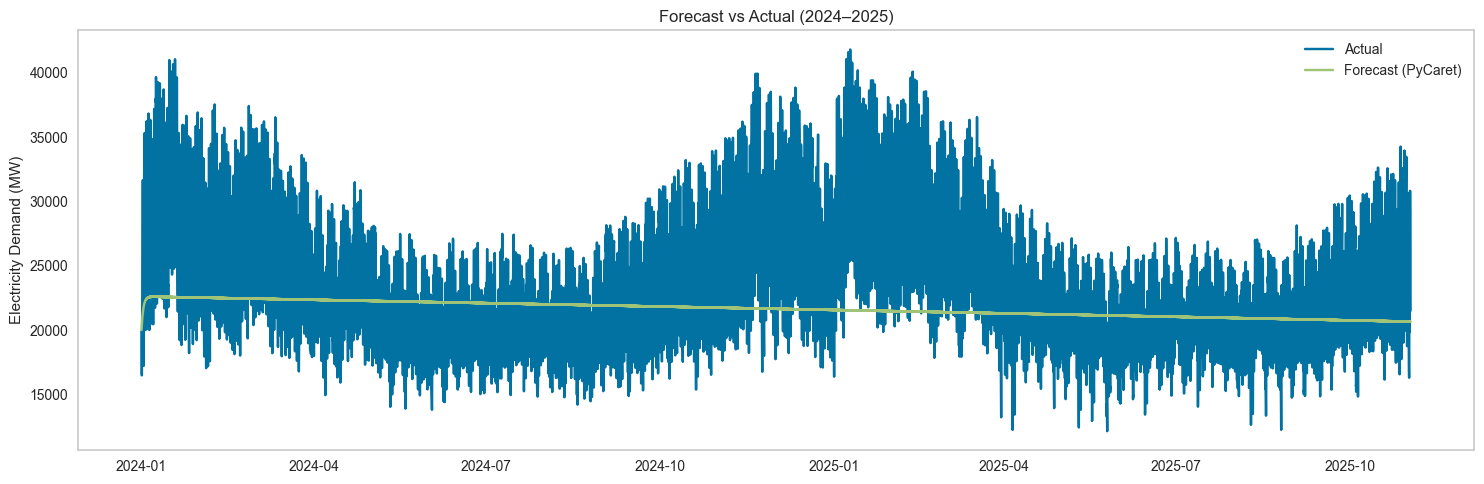


Next 3 weeks (hourly) forecast head:
                         y_pred
2024-01-01 00:00:00  20020.7686
2024-01-01 01:00:00  20120.5398
2024-01-01 02:00:00  20237.7898
2024-01-01 03:00:00  20328.2128
2024-01-01 04:00:00  20436.7361

Next 14 days (daily mean) forecast head:
                  y_pred
2024-01-01  20967.666142
2024-01-02  22037.467454
2024-01-03  22412.890571
2024-01-04  22543.459217
2024-01-05  22587.686175

Next 8 weeks (weekly mean) forecast head:
                  y_pred
2024-01-07  22250.735353
2024-01-14  22596.230867
2024-01-21  22576.836360
2024-01-28  22557.179433
2024-02-04  22537.507283

Predicted demand at 2024-11-23 02:00: 21699.00 MW
Transformation Pipeline and Model Successfully Saved

Model saved to ../models/best_electricity_forecaster


In [ ]:
# =========================
# UK Electricity – PyCaret TS Model
# =========================

# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from pycaret.time_series import TSForecastingExperiment




# 2. Load cleaned data
df = pd.read_parquet("../data/clean/uk_electricity_hourly.parquet")

# Ensure proper datetime index and hourly frequency
df.index = pd.to_datetime(df.index)
df = df.sort_index().asfreq("H")

print("Full data shape:", df.shape)
print("Start:", df.index.min(), "End:", df.index.max())


# 3. Train / Test split
train = df[: "2023-12-31"]
test  = df["2024-01-01":]

print("Train shape:", train.shape)
print("Test shape :", test.shape)

last_train_ts = train.index.max()


# 4. (Optional) Naive baseline for comparison
naive_pred = test["demand_mw"].shift(24)  # yesterday same hour
naive_rmse = np.sqrt(((naive_pred - test["demand_mw"]) ** 2).mean())
print("Naive (yesterday) RMSE:", naive_rmse)


# 5. PyCaret Time Series Experiment Setup
exp = TSForecastingExperiment()

exp.setup(
    data=train["demand_mw"],
    fh=len(test),             # horizon for internal validation
    fold_strategy="sliding",
    fold=3,
    seasonal_period=24 * 7,   # strong weekly seasonality for hourly data
    session_id=42,
    verbose=False
)

# 6. Compare multiple candidate models
candidate_models = [
    "arima",
    "auto_arima",
    "ets",
    "theta",
    "lightgbm_cds_dt",
    "ridge_cds_dt",
    "lasso_cds_dt",
    "rf_cds_dt",
    "lr_cds_dt"
]

best_models = exp.compare_models(
    include=candidate_models,
    n_select=3,
    sort="RMSE"
)

print("Top 3 models:")
for m in best_models:
    print(m)

best = best_models[0]
print("\nBest base model:", best)


# 7. Tune the best model
tuned = exp.tune_model(best)
print("\nTuned model:")
print(tuned)


# 8. Finalize model on full training data
final_model = exp.finalize_model(tuned)
print("\nFinal model:")
print(final_model)


# 9. Evaluate on test set (2024+)
forecast_test = exp.predict_model(final_model, fh=len(test))

rmse = mean_squared_error(test["demand_mw"], forecast_test, squared=False)
mae = mean_absolute_error(test["demand_mw"], forecast_test)

print("\nTest RMSE:", rmse)
print("Test MAE :", mae)
print("Naive RMSE (for reference):", naive_rmse)

# Plot forecast vs actual on test period
plt.figure(figsize=(15, 5))
plt.plot(test.index, test["demand_mw"], label="Actual")
plt.plot(test.index, forecast_test, label="Forecast (PyCaret)")
plt.title("Forecast vs Actual (2024–2025)")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 10. Generic forecasting helpers
def _forecast_hours_ahead(n_hours, model=final_model):
    """
    Forecast n_hours ahead from the end of the training period.
    Returns a pandas Series with a DateTimeIndex.
    """
    if n_hours <= 0:
        raise ValueError("n_hours must be positive.")

    # Use PyCaret to forecast n_hours ahead
    y_pred = exp.predict_model(model, fh=n_hours)

    # Ensure DateTimeIndex starting from last_train_ts + 1 hour
    future_index = pd.date_range(
        start=last_train_ts + pd.Timedelta(hours=1),
        periods=n_hours,
        freq="H"
    )
    y_pred.index = future_index

    return y_pred


def forecast_daily(n_days, model=final_model, agg="mean"):
    """
    Forecast n_days into the future and aggregate to daily values.
    agg: 'mean', 'sum', etc. (resample aggregation)
    """
    hours = n_days * 24
    hourly_fc = _forecast_hours_ahead(hours, model=model)
    return getattr(hourly_fc.resample("D"), agg)()


def forecast_weekly(n_weeks, model=final_model, agg="mean"):
    """
    Forecast n_weeks into the future and aggregate to weekly values.
    agg: 'mean', 'sum', etc. (resample aggregation)
    """
    hours = n_weeks * 7 * 24
    hourly_fc = _forecast_hours_ahead(hours, model=model)
    return getattr(hourly_fc.resample("W"), agg)()


def predict_timestamp(ts, model=final_model):
    """
    Predict demand for an arbitrary timestamp 'ts' (string or pd.Timestamp).
    If ts is within the training period, returns the actual value.
    If ts is after the training period, forecasts forward as needed.
    """
    ts = pd.to_datetime(ts)

    # 1) Timestamp inside training data -> return actual
    if ts <= last_train_ts:
        if ts in train.index:
            return float(train.loc[ts, "demand_mw"])
        else:
            raise ValueError("Timestamp is before training start or not aligned to hourly frequency.")

    # 2) Timestamp after training end -> forecast
    n_hours = int((ts - last_train_ts) / pd.Timedelta(hours=1))
    if n_hours <= 0:
        raise ValueError("Computed non-positive horizon; check timestamp and frequency.")

    fc = _forecast_hours_ahead(n_hours, model=model)

    if ts not in fc.index:
        raise ValueError("Timestamp not aligned to hourly frequency of the forecast.")

    return float(fc.loc[ts])


# 11. Example usages (you can comment these out if you want):

# a) Forecast next 3 weeks hourly
forecast_3w_hourly = _forecast_hours_ahead(3 * 7 * 24)
print("\nNext 3 weeks (hourly) forecast head:")
print(forecast_3w_hourly.head())

# b) Forecast next 14 days, aggregated daily (mean)
forecast_14d_daily = forecast_daily(14)
print("\nNext 14 days (daily mean) forecast head:")
print(forecast_14d_daily.head())

# c) Forecast next 8 weeks, aggregated weekly (mean)
forecast_8w_weekly = forecast_weekly(8)
print("\nNext 8 weeks (weekly mean) forecast head:")
print(forecast_8w_weekly.head())

# d) Predict a specific timestamp
example_ts = "2024-11-23 02:00"
pred_specific = predict_timestamp(example_ts)
print(f"\nPredicted demand at {example_ts}: {pred_specific:.2f} MW")


# 12. Save finalized model for deployment
os.makedirs("../models", exist_ok=True)
exp.save_model(final_model, "../models/best_electricity_forecaster")

print("\nModel saved to ../models/best_electricity_forecaster")
